# BÀI THỰC HÀNH 4: MẠNG NEURAL HỒI QUY

<b>Hướng dẫn nộp bài:</b> Các bạn commit và push code lên github, sử dụng file txt đặt tên theo cú pháp <MSSV>.txt chứa đường link dẫn đến github của bài thực hành và nộp file txt này tên courses.

Bộ dữ liệu sử dụng: [PhoMT](https://drive.google.com/drive/folders/1ksAAeUq2b4u_hiKpyzaEDNzfQDHoB1cI?usp=sharing).

# EDA

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from collections import Counter
import re
import sentencepiece as spm

pd.set_option("display.max_colwidth", None)

In [34]:
# Load dataset
files = ['train.json', 'dev.json', 'test.json']
fnames = ['train', 'dev', 'test']
dataset = {}

for name, file in zip(fnames, files):
    with open(f"Machine-translation-datasets/small-{file}", "r", encoding="utf-8") as f:
        data = json.load(f)
    dataset[name] = pd.DataFrame(data)

train = dataset['train']
dev = dataset['dev']
test = dataset['test']

In [35]:
# Print dataset shape
print(f"Train shape: {train.shape}")
print(f"Dev shape: {dev.shape}")
print(f"Test shape: {test.shape}")

Train shape: (20000, 2)
Dev shape: (2000, 2)
Test shape: (2000, 2)


In [36]:
# Print column name
print("Columns:", train.columns.tolist())

Columns: ['english', 'vietnamese']


In [37]:
# Display first few rows of the training set
train.head()

,english,vietnamese
0,It begins with a countdown .,Câu chuyện bắt đầu với buổi lễ đếm ngược .
1,"On August 14th , 1947 , a woman in Bombay goes into labor as the clock ticks towards midnight .","Ngày 14 , tháng 8 , năm 1947 , gần nửa đêm , ở Bombay , có một phụ nữ sắp lâm bồn ."
2,"Across India , people hold their breath for the declaration of independence after nearly two centuries of British occupation and rule .","Cùng lúc , trên khắp đất Ấn , người ta nín thở chờ đợi tuyên ngôn độc lập sau gần hai thập kỷ là thuộc địa của Anh ."
3,"And at the stroke of midnight , a squirming infant and two new nations are born in perfect synchronicity .","Khi đồng hồ điểm thời khắc nửa đêm , một đứa trẻ và hai quốc gia mới , cùng một lúc , ra đời ."
4,"These events form the foundation of "" Midnight 's Children , "" a dazzling novel by the British - Indian author Salman Rushdie .","Những sự kiện này là nền móng tạo nên "" Những đứa con của nửa đêm , "" một tiểu thuyết nổi tiếng của nhà văn Anh gốc Ấn Salman Rushdie ."


In [38]:
# Check for missing values
print ("Missing values in training set:\n", train.isnull().sum())
print ("Missing values in dev set:\n", dev.isnull().sum())
print ("Missing values in test set:\n", test.isnull().sum())

Missing values in training set:
 english       0
vietnamese    0
dtype: int64
Missing values in dev set:
 english       0
vietnamese    0
dtype: int64
Missing values in test set:
 english       0
vietnamese    0
dtype: int64


In [39]:
# Check for duplicate entries
print("Duplicate entries in training set:", train.duplicated().sum())
print("Duplicate entries in dev set:", dev.duplicated().sum())
print("Duplicate entries in test set:", test.duplicated().sum())

Duplicate entries in training set: 0
Duplicate entries in dev set: 0
Duplicate entries in test set: 0


In [40]:
# Display some duplicate entries
train[train.duplicated(keep=False)].sort_values(by=train.columns.tolist()).head(10)

,english,vietnamese


In [41]:
# Remove duplicate entries
train = train.drop_duplicates().reset_index(drop=True)
dev = dev.drop_duplicates().reset_index(drop=True)
test = test.drop_duplicates().reset_index(drop=True)

# Data shape after removing duplicates
print(f"Train shape after removing duplicates: {train.shape}")
print(f"Dev shape after removing duplicates: {dev.shape}")
print(f"Test shape after removing duplicates: {test.shape}")

Train shape after removing duplicates: (20000, 2)
Dev shape after removing duplicates: (2000, 2)
Test shape after removing duplicates: (2000, 2)


* Dữ liệu đã đạt mức cơ bản, đầy đủ và được xử lý trùng lắp.

### 2. Phân tích độ dài câu

In [42]:
# Function to compute sentence lengths and summary statistics
def sentence_lengths(df):
    eng_lengths = df['english'].apply(lambda x: len(x.split()))
    vie_lengths = df['vietnamese'].apply(lambda x: len(x.split()))

    sumary = pd.concat([eng_lengths.describe().rename("English"), 
                       vie_lengths.describe().rename("Vietnamese")], axis=1)

    return sumary

In [43]:
# Lengths summary for training set
sentence_lengths(train)

,English,Vietnamese
count,20000.000000,20000.000000
mean,19.794350,23.757700
std,13.620537,16.518715
min,3.000000,3.000000
25%,10.000000,12.000000
50%,16.000000,19.000000
75%,26.000000,31.000000
max,164.000000,179.000000


In [44]:
# Lengths summary for dev set
sentence_lengths(dev)

,English,Vietnamese
count,2000.000000,2000.000000
mean,20.008500,25.032000
std,10.936875,13.739227
min,3.000000,3.000000
25%,12.000000,15.000000
50%,18.000000,23.000000
75%,26.000000,32.000000
max,154.000000,184.000000


In [45]:
# Length statistics for test set
sentence_lengths(test)

,English,Vietnamese
count,2000.000000,2000.000000
mean,22.623500,28.793500
std,12.719341,16.661232
min,3.000000,3.000000
25%,13.000000,16.000000
50%,20.000000,25.000000
75%,29.250000,38.000000
max,88.000000,130.000000


In [46]:
# Function to draw histogram plot of sentence lengths
def plot_sentence_lengths(df, dataset_name):
    eng_lengths = df['english'].apply(lambda x: len(x.split()))
    vie_lengths = df['vietnamese'].apply(lambda x: len(x.split()))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(eng_lengths, bins=100, color='blue', alpha=0.7)
    plt.title(f'English Sentence Lengths in {dataset_name} Set')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(vie_lengths, bins=100, color='green', alpha=0.7)
    plt.title(f'Vietnamese Sentence Lengths in {dataset_name} Set')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

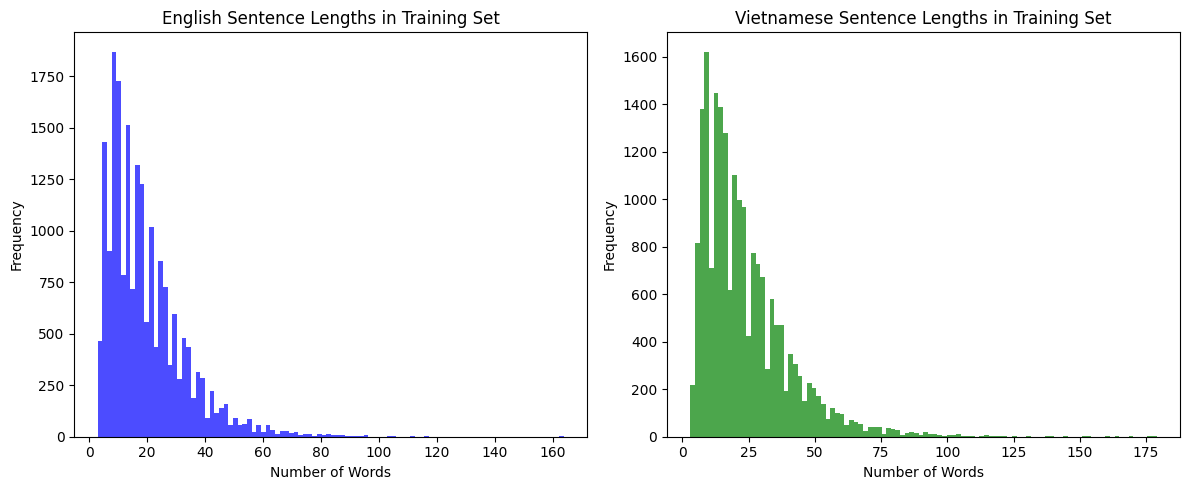

In [47]:
# Visualize sentence lengths for training set
plot_sentence_lengths(train, "Training")

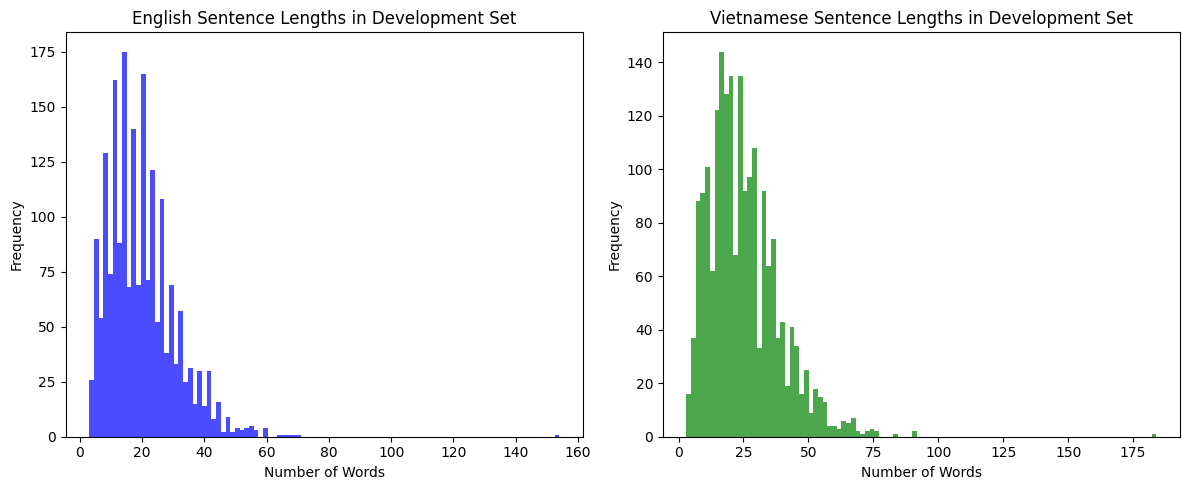

In [48]:
# Visualize sentence lengths for dev set
plot_sentence_lengths(dev, "Development")

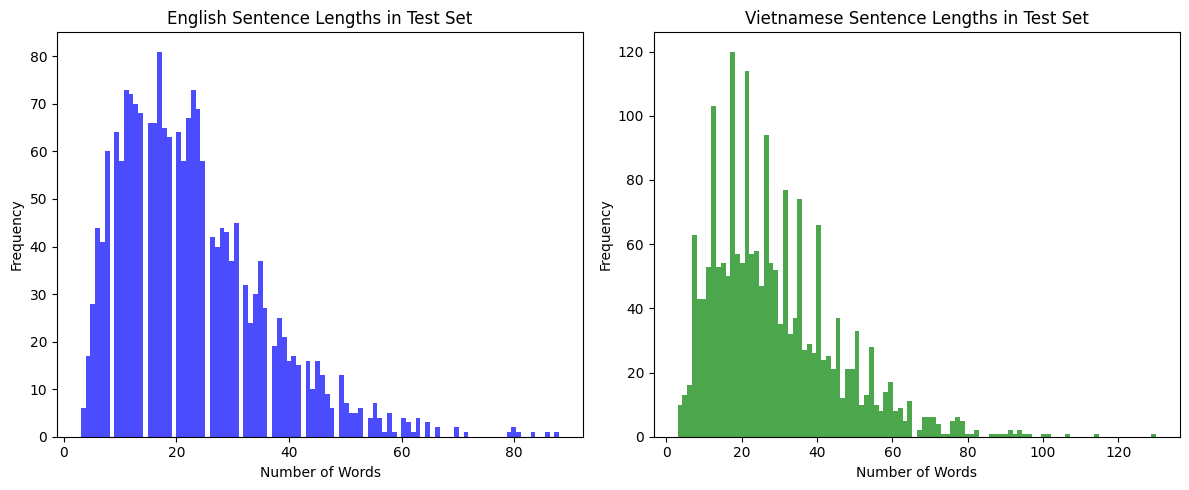

In [49]:
# Visualize sentence lengths for test set
plot_sentence_lengths(test, "Test")

* Tập train với 20.000 cặp câu cho mỗi ngôn ngữ, độ dài câu tiếng Việt dài hơn trung bình khoảng 4 từ so với tiếng Anh (23.76 vs 19.79), đồng thời độ lệch chuẩn cũng cao hơn (16.52 vs 13.62). Mặc dù cả hai ngôn ngữ đều có câu ngắn nhất là 3 từ, câu dài nhất tiếng Việt lên tới 179 từ, vượt xa tiếng Anh với 164 từ. Biểu đồ histogram minh họa rõ sự khác biệt này: cả hai ngôn ngữ đều có phân bố lệch phải, tập trung nhiều ở khoảng dưới 40 từ, nhưng tiếng Việt có dải phân bố rộng hơn, với nhiều câu vượt quá 100 từ. Điều này phản ánh đặc trưng cú pháp tiếng Việt thường diễn đạt dài và đa dạng hơn.

* Tập dev gồm 2.000 câu mỗi ngôn ngữ tiếp tục cho thấy xu hướng tương tự. Độ dài trung bình câu tiếng Việt là 25.03 từ, cao hơn tiếng Anh với 20.01 từ. Độ lệch chuẩn cũng lớn hơn (13.74 so với 10.94), cho thấy sự đa dạng trong cấu trúc câu tiếng Việt. Các giá trị phần tư (25%, 50%, 75%) đều cao hơn ở tiếng Việt, chứng minh rằng không chỉ có một vài câu dài mà toàn bộ phân bố đều nghiêng về phía dài hơn. Câu dài nhất tiếng Việt đạt 184 từ, trong khi tiếng Anh dừng ở 154 từ. Biểu đồ cho thấy tần suất câu tiếng Việt ở khoảng 20–40 từ cao hơn rõ rệt, trong khi tiếng Anh tập trung nhiều hơn ở khoảng ngắn hơn. 

* Tập test cũng gồm 2.000 câu mỗi ngôn ngữ và tiếp tục khẳng định xu hướng trên. Câu tiếng Việt có độ dài trung bình 28.79 từ, cao hơn đáng kể so với tiếng Anh là 22.62 từ. Độ lệch chuẩn ở tiếng Việt là 16.66, phản ánh sự phân tán lớn hơn. Các giá trị phần tư đều cao hơn, đặc biệt là phần tư thứ ba (75%) ở tiếng Việt là 38 từ, so với tiếng Anh là 29.25 từ. Câu dài nhất tiếng Việt lên tới 130 từ, trong khi tiếng Anh là 88 từ, cho thấy sự khác biệt rõ rệt về độ dài cực đại. Biểu đồ histogram cho thấy tiếng Việt có nhiều câu dài trên 50 từ, thậm chí vượt quá 120 từ, trong khi tiếng Anh hiếm khi vượt quá 80 từ.

-> Sự đồng nhất trong phân bố chiều dài câu, các giá trị trung bình, phần tư và độ lệch chuẩn tăng dần một cách ổn định giữa cả ba tập là một điểm mạnh, vì nó giúp kết quả đánh giá cuối cùng trên tập Test trở nên đáng tin cậy và ít bị ảnh hưởng bởi các trường hợp ngoại lệ.

### 3. Kiểm tra sự tương quan độ dài

In [50]:
# Function to draw scatter plot of length sentences
def plot_sentence_length_scatter(df, dataset_name, ax):
    eng_lengths = df['english'].apply(lambda x: len(x.split()))
    vie_lengths = df['vietnamese'].apply(lambda x: len(x.split()))

    plt.figure(figsize=(8, 6))
    ax.scatter(vie_lengths, eng_lengths, alpha=0.3, s=5, color='green')
    
    ax.set_title(f'English vs Vietnamese Sentence Lengths in {dataset_name} Set')
    ax.set_xlabel('Vietnamese Sentence Length (words)')
    ax.set_ylabel('English Sentence Length (words)')
    ax.set_xlim(0, vie_lengths.max() + 5)
    ax.set_ylim(0, eng_lengths.max() + 5)
    ax.grid(True)

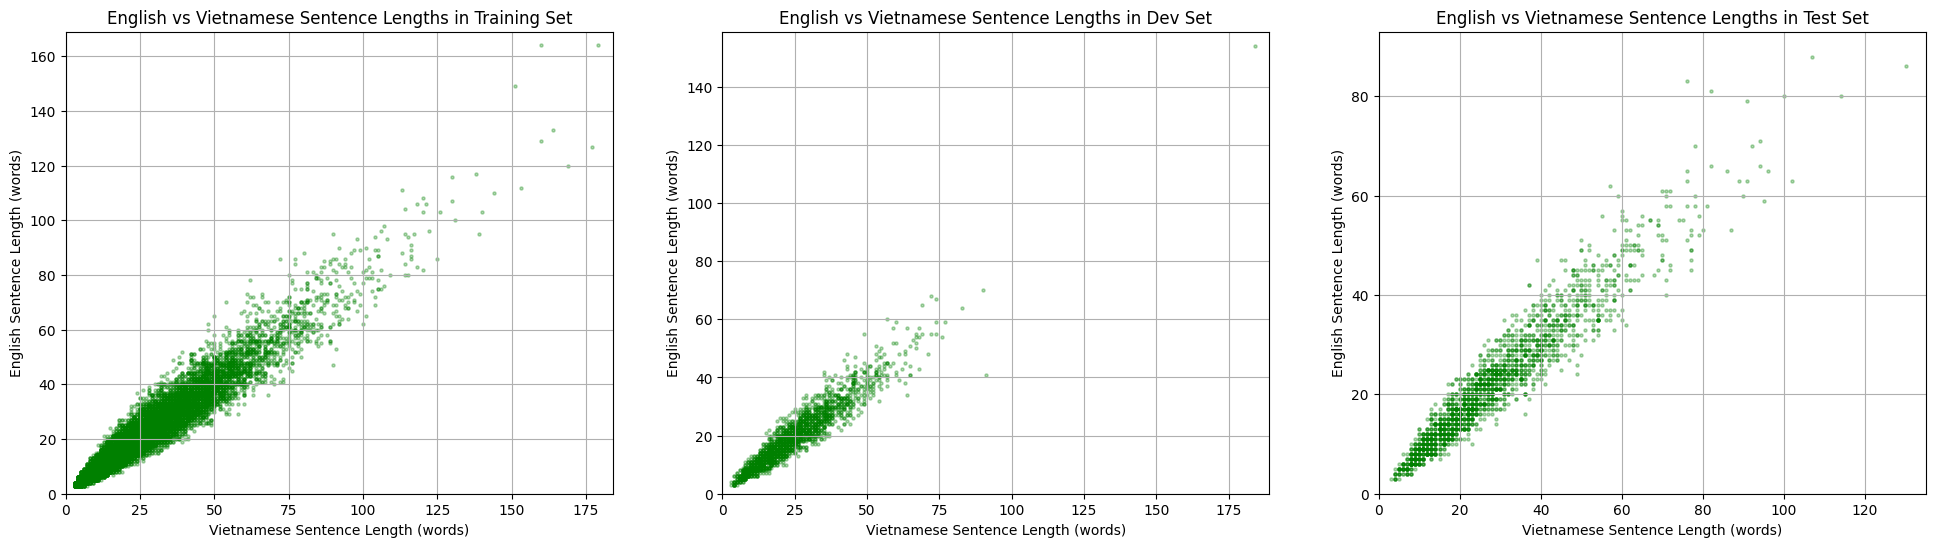

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6))
plot_sentence_length_scatter(train, 'Training', axes[0])
plot_sentence_length_scatter(dev, 'Dev', axes[1])
plot_sentence_length_scatter(test, 'Test', axes[2])
plt.tight_layout()
plt.show()

In [52]:
# Function to calculate length ratios
def length_ratios(df):
    eng_lengths = df['english'].apply(lambda x: len(x.split()))
    vie_lengths = df['vietnamese'].apply(lambda x: len(x.split()))
    
    ratios = eng_lengths / vie_lengths
    return ratios.describe()


In [53]:
# Lengths ratio statistics for training set
length_ratios(train)

count    20000.000000
mean         0.851397
std          0.165653
min          0.416667
25%          0.736842
50%          0.833333
75%          0.944444
max          1.636364
dtype: float64

In [54]:
# Lengths ratio statistics for dev set
length_ratios(dev)

count    2000.000000
mean        0.814737
std         0.147247
min         0.437500
25%         0.714286
50%         0.800000
75%         0.900000
max         1.500000
dtype: float64

In [55]:
# Lengths ratio statistics for test set
length_ratios(test)

count    2000.000000
mean        0.802567
std         0.138174
min         0.434783
25%         0.705882
50%         0.791667
75%         0.888889
max         1.333333
dtype: float64

* Scatter Plot cho thấy độ dài câu tiếng Việt và tiếng Anh có mối tương quan tuyến tính dương: khi câu tiếng Việt dài hơn thì câu tiếng Anh tương ứng cũng có xu hướng dài hơn, tuy nhiên, câu Tiếng Việt có xu hướng dài hơn một chút. 

* Scatter Plot cho thấy câu Tiếng Anh dài hơn thì câu Tiếng Việt dịch tương ứng cũng dài hơn. 

* Tỷ lệ chiều dài (English Length / Vietnamese Length) với giá trị Trung bình (Mean) nằm dưới 1.0 ở cả ba tập, dao động từ 0.80 đến 0.85, nghĩa là câu tiếng Anh thường ngắn hơn khoảng 15–20% so với câu tiếng Việt.

* Giá trị min ổn định (~0.42–0.44) ở cả ba tập, chứng tỏ luôn tồn tại những câu tiếng Anh ngắn hơn nhiều so với tiếng Việt. Giá trị max giảm dần từ Train (1.64) -> Dev (1.50) -> Test (1.33), cho thấy dữ liệu ở Dev và Test đã được lọc kỹ hơn, hạn chế ngoại lệ.

### 4. Phân tích từ vựng

In [56]:
# Function to calculate unique tokens in English and Vietnamese
def unique_tokens(df):
    eng_counter = Counter()
    vie_counter = Counter()

    for sentence in df['english']:
        eng_counter.update(sentence.split())

    for sentence in df['vietnamese']:
        vie_counter.update(sentence.split())

    return eng_counter, vie_counter

In [57]:
# Unique tokens in English and Vietnamese
train_token = unique_tokens(train)
dev_token = unique_tokens(dev)
test_token = unique_tokens(test)


print (f"Unique tokens in training set: ({len(train_token[0])}, {len(train_token[0])})")
print (f"Unique tokens in dev set: ({len(dev_token[0])}, {len(dev_token[0])})")
print (f"Unique tokens in test set: ({len(test_token[0])}, {len(test_token[0])})")

Unique tokens in training set: (19061, 19061)
Unique tokens in dev set: (6301, 6301)
Unique tokens in test set: (6416, 6416)


In [58]:
# Top 10 most frequent tokens in English and Vietnamese
print ("Top 10 tokens in training set:\n", train_token[0].most_common(10), train_token[1].most_common(10))
print ("Top 10 tokens in dev set:\n", dev_token[0].most_common(10), dev_token[1].most_common(10))
print ("Top 10 tokens in test set:\n", test_token[0].most_common(10), test_token[1].most_common(10))

Top 10 tokens in training set:
 [(',', 23180), ('.', 18302), ('the', 14556), ('to', 9433), ('of', 8532), ('and', 8242), ('a', 7647), ('that', 7083), ('I', 5973), ('in', 5556)] [(',', 19699), ('.', 16254), ('là', 8091), ('tôi', 7122), ('và', 7024), ('có', 6977), ('một', 6598), ('chúng', 5131), ('những', 5037), ('của', 4960)]
Top 10 tokens in dev set:
 [(',', 2170), ('.', 1872), ('the', 1573), ('of', 995), ('to', 959), ('and', 863), ('a', 814), ('in', 616), ('that', 509), ('I', 423)] [(',', 1979), ('.', 1791), ('và', 754), ('một', 723), ('là', 710), ('có', 655), ('của', 651), ('tôi', 581), ('những', 466), ('chúng', 391)]
Top 10 tokens in test set:
 [(',', 2488), ('the', 1907), ('.', 1882), ('of', 1202), ('to', 1155), ('and', 993), ('a', 828), ('in', 745), ('that', 714), ('is', 500)] [(',', 2176), ('.', 1835), ('và', 944), ('là', 856), ('có', 817), ('một', 801), ('những', 786), ('của', 688), ('chúng', 536), ('người', 468)]


* Phân bố tần suất Token cho thấy bộ dữ liệu có sự đa dạng từ vựng lớn nhưng bị chi phối bởi một nhóm nhỏ các từ phổ biến và dấu câu. 

* Tập Training có 19061 token duy nhất, trong khi các tập Dev và Test có 6301 đến 6416 token duy nhất. 

* Cả ba tập đều thể hiện sự nhất quán cao trong Top 10 token phổ biến (chủ yếu là dấu câu và từ dừng như '.', ',', 'the', 'và', 'là'). Sự nhất quán này, cùng với sự đồng nhất về phân bố chiều dài câu, xác nhận rằng tập Dev và Test là mẫu đại diện tin cậy cho phân bố dữ liệu trong tập Training, điều này là lý tưởng cho việc đánh giá mô hình.

### 4. Tiền xử lý

In [59]:
# Preprocessing function
def preprocess_dataset(df, max_len=100, min_len=2, length_ratio_threshold=3.0):

    def normalize_text(text):
        text = text.lower().strip()
        text = re.sub(r"\s+", " ", text)
        text = re.sub(r"[^\w\s.,!?]", "", text)
        return text
    
    df.loc[:, "english"] = df["english"].apply(normalize_text)
    df.loc[:, "vietnamese"] = df["vietnamese"].apply(normalize_text)


    len_en = df["english"].apply(lambda x: len(x.split()))
    len_vi = df["vietnamese"].apply(lambda x: len(x.split()))
    
    mask = (len_en >= min_len) & (len_en <= max_len) & \
           (len_vi >= min_len) & (len_vi <= max_len)
    df = df[mask]
    
    mask_ratio = (len_en / len_vi <= length_ratio_threshold) & \
                 (len_vi / len_en <= length_ratio_threshold)
    df = df[mask_ratio]
    
    return df[["english", "vietnamese"]].reset_index(drop=True)


In [60]:
# Sample preprocessing on a small subset
train_sample = train.head(5)
train_clean = preprocess_dataset(train_sample)
for i in range(len(train_clean)):
    print(f"\nEN: {train_sample.iloc[i]['english']} -> {train_clean.iloc[i]['english']}")
    print(f"VI: {train_sample.iloc[i]['vietnamese']} -> {train_clean.iloc[i]['vietnamese']}")


EN: it begins with a countdown . -> it begins with a countdown .
VI: câu chuyện bắt đầu với buổi lễ đếm ngược . -> câu chuyện bắt đầu với buổi lễ đếm ngược .

EN: on august 14th , 1947 , a woman in bombay goes into labor as the clock ticks towards midnight . -> on august 14th , 1947 , a woman in bombay goes into labor as the clock ticks towards midnight .
VI: ngày 14 , tháng 8 , năm 1947 , gần nửa đêm , ở bombay , có một phụ nữ sắp lâm bồn . -> ngày 14 , tháng 8 , năm 1947 , gần nửa đêm , ở bombay , có một phụ nữ sắp lâm bồn .

EN: across india , people hold their breath for the declaration of independence after nearly two centuries of british occupation and rule . -> across india , people hold their breath for the declaration of independence after nearly two centuries of british occupation and rule .
VI: cùng lúc , trên khắp đất ấn , người ta nín thở chờ đợi tuyên ngôn độc lập sau gần hai thập kỷ là thuộc địa của anh . -> cùng lúc , trên khắp đất ấn , người ta nín thở chờ đợi tuyên n

Tiến hành tiền xử lý cơ bản gồm:
* Chuyển toàn bộ văn bản về chữ thường.
* Bỏ khoảng trắng thừa và ký tự đặc biệt.
* Tính độ dài câu để lọc bỏ những câu quá ngắn hoặc quá dài.
* Loại bỏ các cặp câu có độ dài lệch nhau vượt quá ngưỡng cho phép.

In [61]:
# Prepare cleaned datasets
train_clean = preprocess_dataset(train)
dev_clean = preprocess_dataset(dev)
test_clean = preprocess_dataset(test)

C:\Users\PC\AppData\Local\Temp\ipykernel_23616\441779386.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[mask_ratio]
C:\Users\PC\AppData\Local\Temp\ipykernel_23616\441779386.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[mask_ratio]
C:\Users\PC\AppData\Local\Temp\ipykernel_23616\441779386.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[mask_ratio]


In [62]:
# Save as csv files
train_clean.to_csv("train_clean.csv", index=False, encoding="utf-8")
dev_clean.to_csv("dev_clean.csv", index=False, encoding="utf-8")
test_clean.to_csv("test_clean.csv", index=False, encoding="utf-8")

#### Bài 1: Xây dựng kiến trúc Encoder-Decoder gồm 3 lớp LSTM cho module encoder và 3 lớp LSTM cho module decoder, với hidden size là 256, cho bài toán dịch máy từ tiếng Anh sang tiếng Việt. Huấn luyện mô hình này trên bộ dữ liệu PhoMT sử dụng Adam làm phương thức tối ưu tham số. Đánh giá độ hiệu quả của mô hình sử dụng độ đo ROUGE-L.

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils as utils
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
import random
from rouge_score import rouge_scorer
from tqdm import tqdm


In [30]:
# Load cleaned datasets
train = pd.read_csv("train_clean.csv")
dev = pd.read_csv("dev_clean.csv")
test = pd.read_csv("test_clean.csv")

In [31]:
class Vocab:
    def __init__(self, sentences, min_freq=2):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {v: k for k, v in self.itos.items()}
        
        words = [word for sent in sentences for word in str(sent).split()]
        word_counts = Counter(words)
        
        idx = 4
        for word, count in word_counts.items():
            if count >= min_freq:
                self.stoi[word] = idx
                self.itos[idx] = word
                idx += 1
    
    def __len__(self):
        return len(self.itos)

    def encode(self, text):
        return [self.stoi.get(word, 3) for word in str(text).split()]

In [36]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=256, hid_dim=256, n_layers=3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, hid_dim, n_layers, batch_first=True, dropout=0.3)
        
    def forward(self, src):
        embedded = self.embedding(src)
        outputs, (hidden, cell) = self.lstm(embedded)
        return outputs, hidden, cell

class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=256, hid_dim=256, n_layers=3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, hid_dim, n_layers, batch_first=True, dropout=0.3)
        self.fc_out = nn.Linear(hid_dim, vocab_size)
        
    def forward(self, input_step, hidden, cell):
        embedded = self.embedding(input_step)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(1))
        return prediction, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, tgt, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        tgt_len = tgt.shape[1]
        vocab_size = self.decoder.fc_out.out_features
        
        outputs = torch.zeros(batch_size, tgt_len, vocab_size).to(self.device)
        enc_outputs, hidden, cell = self.encoder(src)
        
        input_step = tgt[:, 0].unsqueeze(1)
        
        for t in range(1, tgt_len):
            prediction, hidden, cell = self.decoder(input_step, hidden, cell)
            outputs[:, t] = prediction
            
            teacher_force = random.random() < teacher_forcing_ratio
            top_token = prediction.argmax(1).unsqueeze(1)
            input_step = tgt[:, t].unsqueeze(1) if teacher_force else top_token
            
        return outputs

In [33]:
class TranslationDataset(Dataset):
    def __init__(self, df, src_vocab, tgt_vocab):
        self.df = df
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        src = torch.tensor(self.src_vocab.encode(self.df.iloc[idx]['english']))
        tgt = torch.tensor([1] + self.tgt_vocab.encode(self.df.iloc[idx]['vietnamese']) + [2])
        return src, tgt

# Collate function for DataLoader
def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)
    src_batch = pad_sequence(src_batch, batch_first=True, padding_value=0)
    tgt_batch = pad_sequence(tgt_batch, batch_first=True, padding_value=0)
    return src_batch, tgt_batch

In [34]:
# Training and evaluation functions
def train_epoch(model, loader, optimizer, criterion, clip=1):
    model.train()
    epoch_loss = 0
    pbar = tqdm(loader, desc="Training")
    
    for src, tgt in pbar:
        src, tgt = src.to(model.device), tgt.to(model.device)
        optimizer.zero_grad()
        output = model(src, tgt)
        
        output_dim = output.shape[-1]
        output = output[:, 1:, :].reshape(-1, output_dim)
        tgt = tgt[:, 1:].reshape(-1)
        
        loss = criterion(output, tgt)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        epoch_loss += loss.item()
        pbar.set_postfix(loss=loss.item())
        
    return epoch_loss / len(loader)

def evaluate_rouge(model, loader, vi_vocab):
    model.eval()
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    all_preds, all_targets = [], []
    
    with torch.no_grad():
        for src, tgt in tqdm(loader, desc="Evaluating"):
            src, tgt = src.to(model.device), tgt.to(model.device)
            output = model(src, tgt, teacher_forcing_ratio=0) 
            preds = output.argmax(2).cpu().numpy()
            targets = tgt.cpu().numpy()
            
            for p, t in zip(preds, targets):
                p_text = " ".join([vi_vocab.itos[i] for i in p if i > 3])
                t_text = " ".join([vi_vocab.itos[i] for i in t if i > 3])
                
                if not p_text.strip(): p_text = " "
                
                all_preds.append(p_text)
                all_targets.append(t_text)
                
    scores = [scorer.score(t, p)['rougeL'].fmeasure for p, t in zip(all_preds, all_targets)]
    return np.mean(scores)

In [ ]:
# Configurations
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# List to store training history
train_losses = []
valid_rouges = []

# Initialize vocabularies, model, optimizer, and loss function
en_vocab = Vocab(train['english'])
vi_vocab = Vocab(train['vietnamese'])

# Model, optimizer, and loss function
model = Seq2Seq(
    Encoder(len(en_vocab)), 
    Decoder(len(vi_vocab)), 
    device
).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)

# Initialize Dataloader
train_loader = DataLoader(TranslationDataset(train, en_vocab, vi_vocab), batch_size=32, shuffle=True, collate_fn=collate_fn)
dev_loader = DataLoader(TranslationDataset(dev, en_vocab, vi_vocab), batch_size=32, collate_fn=collate_fn)
test_loader = DataLoader(TranslationDataset(test, en_vocab, vi_vocab), batch_size=32, collate_fn=collate_fn)

# Checkpoint functions
def save_checkpoint(model, optimizer, filename="seq2seq_attention.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)

# Training loop
for epoch in range(10):
    loss = train_epoch(model, train_loader, optimizer, criterion)
    train_losses.append(loss)
    
    rouge = evaluate_rouge(model, dev_loader, vi_vocab)
    valid_rouges.append(rouge)
    
    print(f"Epoch {epoch+1}/10 | Train Loss: {loss:.4f} | Dev ROUGE-L: {rouge:.4f}")
    save_checkpoint(model, optimizer, filename=f"model_epoch_{epoch+1}.pth.tar")


Evaluating: 100%|██████████| 63/63 [00:15<00:00,  4.08it/s]


Epoch 1/5 | Train Loss: 6.1175 | Dev ROUGE-L: 0.2454
=> Saving checkpoint


Evaluating: 100%|██████████| 63/63 [00:15<00:00,  4.15it/s]


Epoch 2/5 | Train Loss: 5.8359 | Dev ROUGE-L: 0.1439
=> Saving checkpoint


Evaluating: 100%|██████████| 63/63 [00:14<00:00,  4.20it/s]


Epoch 3/5 | Train Loss: 5.6470 | Dev ROUGE-L: 0.1265
=> Saving checkpoint


Evaluating: 100%|██████████| 63/63 [00:15<00:00,  4.04it/s]


Epoch 4/5 | Train Loss: 5.5049 | Dev ROUGE-L: 0.1666
=> Saving checkpoint


Evaluating: 100%|██████████| 63/63 [00:14<00:00,  4.20it/s]


Epoch 5/5 | Train Loss: 5.3780 | Dev ROUGE-L: 0.1922
=> Saving checkpoint


Evaluating: 100%|██████████| 63/63 [00:15<00:00,  4.07it/s]


Epoch 6/5 | Train Loss: 5.2771 | Dev ROUGE-L: 0.2185
=> Saving checkpoint


Evaluating: 100%|██████████| 63/63 [00:15<00:00,  3.99it/s]


Epoch 7/5 | Train Loss: 5.1950 | Dev ROUGE-L: 0.2337
=> Saving checkpoint


Evaluating: 100%|██████████| 63/63 [00:14<00:00,  4.20it/s]


Epoch 8/5 | Train Loss: 5.1124 | Dev ROUGE-L: 0.2690
=> Saving checkpoint


Evaluating: 100%|██████████| 63/63 [00:15<00:00,  4.17it/s]


Epoch 9/5 | Train Loss: 5.0448 | Dev ROUGE-L: 0.2460
=> Saving checkpoint


Evaluating: 100%|██████████| 63/63 [00:16<00:00,  3.79it/s]


Epoch 10/5 | Train Loss: 4.9877 | Dev ROUGE-L: 0.2576
=> Saving checkpoint


In [38]:
# Function to plot training history
def plot_history(losses, rouges):
    epochs = range(1, len(losses) + 1)
    
    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Train Loss', color=color)
    ax1.plot(epochs, losses, color=color, marker='o', label='Loss')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('ROUGE-L Score', color=color)
    ax2.plot(epochs, rouges, color=color, marker='s', label='ROUGE-L')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title('Training Profile: Loss and ROUGE-L per Epoch')
    fig.tight_layout()
    plt.grid(True, linestyle='--')
    plt.show()

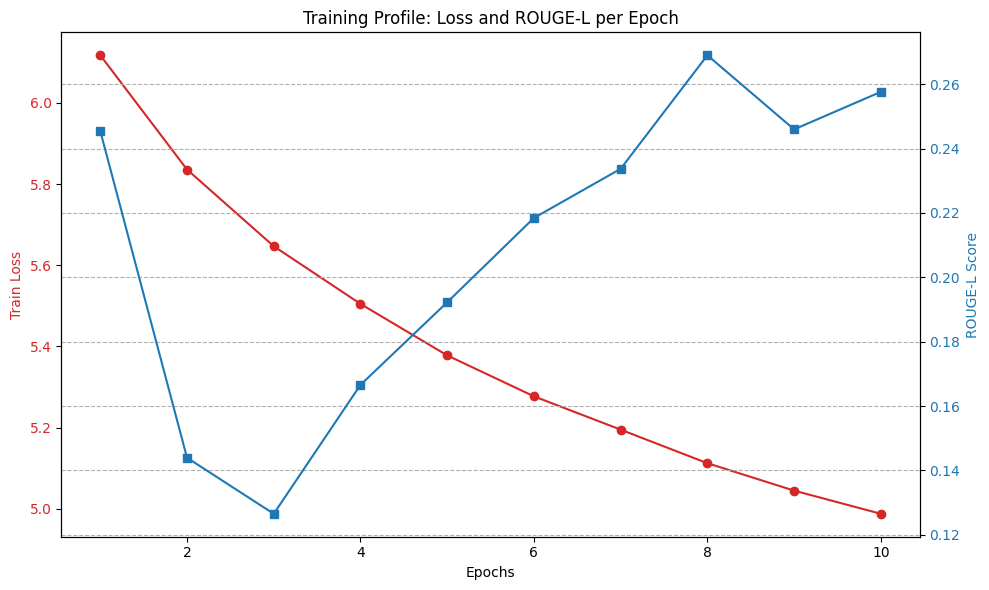

In [39]:
# Plot training history
plot_history(train_losses, valid_rouges)

* Train Loss (màu đỏ) có xu hướng giảm đều và ổn định từ mức ~6.1 xuống còn ~5.0 sau 10 epoch. Chứng tỏ mô hình đang học tốt, các tham số được tối ưu hóa hiệu quả bởi thuật toán Adam. Việc Loss giảm mượt mà cho thấy mức learning rate = 0.001 và cơ chế gradient clipping bạn thiết lập là phù hợp, giúp ổn định quá trình hội tụ của 3 lớp LSTM.

* ROUGE-L (màu xanh) có sự biến động trong 3 epoch đầu (giảm nhẹ), nhưng sau đó tăng mạnh và đạt đỉnh ở epoch 8 (~ 0.27), sau đó dao động nhẹ ở các epoch cuối. Việc ROUGE-L tăng dần cho thấy khả năng dịch thuật của mô hình ngày càng tiệm cận với câu gốc của con người. 

* Mô hình đạt trạng thái tốt nhất tại epoch thứ 8, mốc tối thiểu hóa hàm mất mát và tối đa hóa độ đo ROUGE-L. Mặc dù ở các epoch cuối (9 và 10), chỉ số ROUGE-L có dấu hiệu dao động nhẹ trong khi Loss vẫn tiếp tục giảm, cho thấy mô hình bắt đầu có hiện tượng overfitting nhẹ trên tập huấn luyện.

In [40]:
# Evaluation function using ROUGE-L
final_rouge = evaluate_rouge(model, test_loader, vi_vocab)
print(f"Final ROUGE-L: {final_rouge:.4f}")

Evaluating: 100%|██████████| 63/63 [00:18<00:00,  3.45it/s]


Final ROUGE-L: 0.2588


* Kết quả Final ROUGE-L: 0.2588 đối với một mô hình Seq2Seq cơ bản với 3 lớp LSTM huấn luyện trong 10 epoch trên bộ dữ liệu dịch máy phức tạp như Anh-Việt, là một kết quả rất khả quan. Nó cho thấy bản dịch của mô hình có độ tương đồng khá cao về mặt từ vựng và thứ tự từ so với câu gốc của người dịch.

* Cái tiến: Nâng cấp lên kiến trúc Transformer với cơ chế Self-Attention là ưu tiên hàng đầu để tối ưu hóa khả năng học ngữ cảnh xa và song song hóa tính toán. Ngoài ra, việc kết hợp tiền xử lý tách từ tiếng Việt (Word Segmentation), sử dụng đơn vị Subword thay vì cấp độ từ, và áp dụng chiến lược giải mã Beam Search sẽ giúp bản dịch tự nhiên hơn.

#### Bài 2: Xây dựng kiến trúc Encoder-Decoder gồm 3 lớp LSTM cho module encoder và 3 lớp LSTM cho module decoder, với hidden size là 256, cho bài toán dịch máy từ tiếng Anh sang tiếng Việt. Module decoder được trang bị kỹ thuật attention theo mô tả của nghiên cứu "[Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473)". Huấn luyện mô hình này trên bộ dữ liệu PhoMT sử dụng Adam làm phương thức tối ưu tham số. Đánh giá độ hiệu quả của mô hình sử dụn độ đo ROUGE-L.

In [43]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.W = nn.Linear(hidden_size, hidden_size)
        self.U = nn.Linear(hidden_size, hidden_size)
        self.v = nn.Linear(hidden_size, 1)

    def forward(self, hidden, encoder_outputs):
        
        hidden = hidden.unsqueeze(1)

        energy = torch.tanh(self.W(hidden) + self.U(encoder_outputs))
        attention_scores = self.v(energy).squeeze(2)
        
        attention_weights = torch.softmax(attention_scores, dim=1)
        
        context = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs).squeeze(1)
        return context, attention_weights

class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=256, hid_dim=256, n_layers=3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, hid_dim, n_layers, batch_first=True, dropout=0.3)

    def forward(self, src):
        embedded = self.embedding(src)
        outputs, (hidden, cell) = self.lstm(embedded)
        return outputs, hidden, cell

class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=256, hid_dim=256, n_layers=3):
        super().__init__()
        self.attention = BahdanauAttention(hid_dim)
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim + hid_dim, hid_dim, n_layers, batch_first=True, dropout=0.3)
        self.fc_out = nn.Linear(hid_dim * 2, vocab_size)

    def forward(self, input_step, hidden, cell, encoder_outputs):
        embedded = self.embedding(input_step)

        context, _ = self.attention(hidden[-1], encoder_outputs)
        
        rnn_input = torch.cat([embedded, context.unsqueeze(1)], dim=2)
        output, (hidden, cell) = self.lstm(rnn_input, (hidden, cell))

        prediction = self.fc_out(torch.cat([output.squeeze(1), context], dim=1))
        return prediction, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, tgt, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        tgt_len = tgt.shape[1]
        vocab_size = self.decoder.fc_out.out_features
        outputs = torch.zeros(batch_size, tgt_len, vocab_size).to(self.device)
        
        enc_outputs, hidden, cell = self.encoder(src)
        input_step = tgt[:, 0].unsqueeze(1)

        for t in range(1, tgt_len):
            prediction, hidden, cell = self.decoder(input_step, hidden, cell, enc_outputs)
            outputs[:, t] = prediction
            teacher_force = random.random() < teacher_forcing_ratio
            input_step = tgt[:, t].unsqueeze(1) if teacher_force else prediction.argmax(1).unsqueeze(1)
        return outputs

In [44]:
# Initialize vocabularies, model, optimizer, and loss function
enc = Encoder(vocab_size=len(en_vocab), emb_dim=256, hid_dim=256, n_layers=3)
dec = Decoder(vocab_size=len(vi_vocab), emb_dim=256, hid_dim=256, n_layers=3) 
model = Seq2Seq(enc, dec, device).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0) 

train_losses = []
valid_rouges = []

for epoch in range(5):

    loss = train_epoch(model, train_loader, optimizer, criterion)
    train_losses.append(loss)

    rouge = evaluate_rouge(model, dev_loader, vi_vocab)
    valid_rouges.append(rouge)
    
    print(f"Epoch {epoch+1}/5 | Train Loss: {loss:.4f} | Dev ROUGE-L: {rouge:.4f}")

    save_checkpoint(model, optimizer, filename=f"attention_model_epoch_{epoch+1}.pth.tar")

Evaluating: 100%|██████████| 63/63 [00:57<00:00,  1.09it/s]


Epoch 1/5 | Train Loss: 6.0433 | Dev ROUGE-L: 0.1417
=> Saving checkpoint


Evaluating: 100%|██████████| 63/63 [00:58<00:00,  1.07it/s]


Epoch 2/5 | Train Loss: 5.6060 | Dev ROUGE-L: 0.2670
=> Saving checkpoint


Evaluating: 100%|██████████| 63/63 [00:31<00:00,  1.97it/s]


Epoch 3/5 | Train Loss: 5.2170 | Dev ROUGE-L: 0.3089
=> Saving checkpoint


Evaluating: 100%|██████████| 63/63 [00:29<00:00,  2.10it/s]


Epoch 4/5 | Train Loss: 4.8933 | Dev ROUGE-L: 0.3340
=> Saving checkpoint


Evaluating: 100%|██████████| 63/63 [00:28<00:00,  2.21it/s]


Epoch 5/5 | Train Loss: 4.6411 | Dev ROUGE-L: 0.3450
=> Saving checkpoint


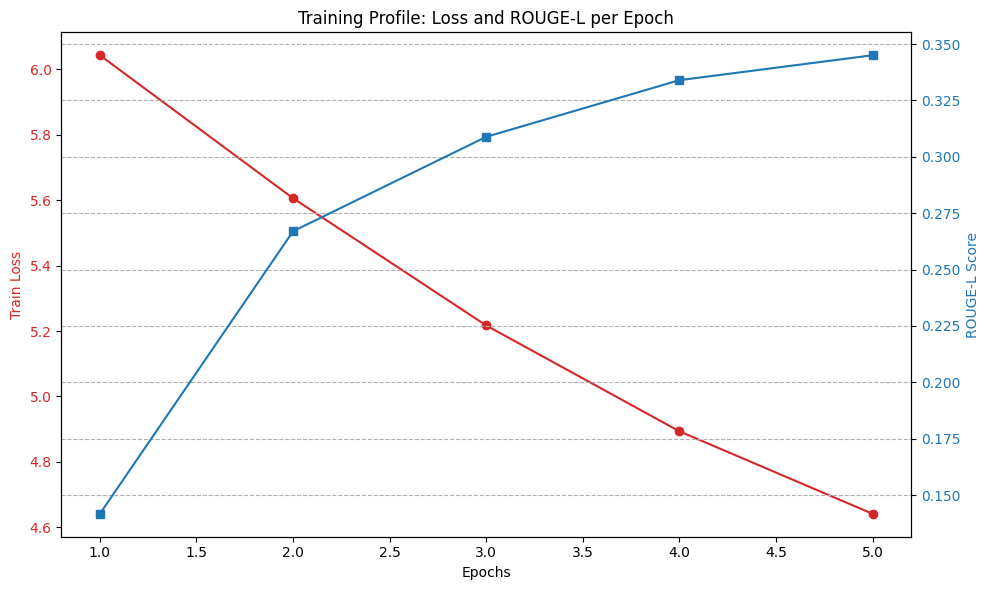

In [45]:
# Plot training history
plot_history(train_losses, valid_rouges)

* Train Loss (màu đỏ) giảm rất đều và ổn định từ mức ~6.0 xuống còn ~4.6 sau 5 epoch. Điều này cho thấy mô hình đang hội tụ tốt.

* ROUGE-L Score (màu xanh) tăng vượt bậc, đặc biệt là giai đoạn từ Epoch 1 đến Epoch 3. Điểm số tăng từ khoảng 0.14 lên gần 0.35 trên tập Validation, chứng tỏ mô hình bắt đầu hiểu được cấu trúc ngữ pháp và từ vựng tiếng Việt rất nhanh sau khi vượt qua giai đoạn khởi đầu.

In [46]:
# Evaluation function using ROUGE-L
final_rouge = evaluate_rouge(model, test_loader, vi_vocab)
print(f"Final ROUGE-L: {final_rouge:.4f}")

Evaluating: 100%|██████████| 63/63 [00:34<00:00,  1.82it/s]


Final ROUGE-L: 0.3562


* Kết quả 0.3562 cho thấy mô hình hiện tại đã có khả năng dịch các câu với độ chính xác về từ vựng và cấu trúc ngữ pháp tương đối tốt. Điểm trên tập Test (0.3562) cao hơn một chút so với Validation (~0.345) cho thấy mô hình có khả năng tổng quát hóa.

* Việc tích hợp cơ chế Attention vào mô hình Seq2Seq đã tạo ra một bước đột phá về hiệu suất, giúp điểm ROUGE-L tăng từ 0.2588 (Bài 1) lên 0.3562 (Bài 2). Sự chênh lệch này khẳng định rằng cơ chế này giúp mô hình ghi nhớ ngữ cảnh tốt hơn và dịch thuật chính xác hơn do Bahdanau Attention cho phép Decoder tính toán trọng số tương quan để tập trung vào các từ cụ thể trong câu gốc tại mỗi bước dịch, thay vì chỉ dựa vào một vector nén cố định như mô hình Seq2Seq thuần túy.

In [ ]:
# Translation function
def translate_sentence(sentence, src_vocab, tgt_vocab, model, device, max_len=50):
    model.eval()
    
    if isinstance(sentence, str):
        tokens = [token.lower() for token in sentence.split()]
    else:
        tokens = [token.lower() for token in sentence]
        
    src_indices = src_vocab.encode(" ".join(tokens))
    src_tensor = torch.LongTensor(src_indices).unsqueeze(0).to(device)
    
    with torch.no_grad():
        encoder_outputs, hidden, cell = model.encoder(src_tensor)

    trg_indices = [1] 
    
    for i in range(max_len):
        trg_tensor = torch.LongTensor([[trg_indices[-1]]]).to(device)
        
        with torch.no_grad():
            output, hidden, cell = model.decoder(trg_tensor, hidden, cell, encoder_outputs)

        prediction = output.argmax(1).item()
        trg_indices.append(prediction)
        
        if prediction == 2:
            break

    translated_tokens = [tgt_vocab.itos[i] for i in trg_indices if i > 3]
    return " ".join(translated_tokens)

In [ ]:
# Example translation
sentence = " you can talk with me"
translation = translate_sentence(sentence, en_vocab, vi_vocab, model, device)
print(f'Predicted: {translation}')

Predicted: bạn có thể nói với với mình .


#### Bài 3: Xây dựng kiến trúc Encoder-Decoder gồm 3 lớp LSTM cho module encoder và 3 lớp LSTM cho module decoder, với hidden size là 256, cho bài toán dịch máy từ tiếng Anh sang tiếng Việt. Module decoder được trang bị kỹ thuật attention theo mô tả của nghiên cứu "[Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025)". Huấn luyện mô hình này trên bộ dữ liệu PhoMT sử dụng Adam làm phương thức tối ưu tham số. Đánh giá độ hiệu quả của mô hình sử dụn độ đo ROUGE-L.

In [58]:
class LuongAttention(nn.Module):
    def __init__(self, hidden_size):
        super(LuongAttention, self).__init__()

        self.wa = nn.Linear(hidden_size, hidden_size)

    def forward(self, decoder_hidden, encoder_outputs):

        score = torch.bmm(self.wa(decoder_hidden), encoder_outputs.transpose(1, 2))

        attention_weights = F.softmax(score, dim=-1)
        
        context = torch.bmm(attention_weights, encoder_outputs)
        return context, attention_weights


class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=256, hid_dim=256, n_layers=3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, hid_dim, n_layers, batch_first=True, dropout=0.3)

    def forward(self, src):
        embedded = self.embedding(src)
        outputs, (hidden, cell) = self.lstm(embedded)
        # outputs: [batch, seq_len, hid_dim]
        return outputs, hidden, cell

class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=256, hid_dim=256, n_layers=3):
        super().__init__()
        self.attention = LuongAttention(hid_dim)
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, hid_dim, n_layers, batch_first=True, dropout=0.3)
        
        self.wc = nn.Linear(hid_dim * 2, hid_dim)
        self.fc_out = nn.Linear(hid_dim, vocab_size)

    def forward(self, input_step, hidden, cell, encoder_outputs):
        embedded = self.embedding(input_step)
        
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))

        context, _ = self.attention(output, encoder_outputs)

        combined = torch.cat([output, context], dim=2)
        att_hidden = torch.tanh(self.wc(combined.squeeze(1)))
        
        prediction = self.fc_out(att_hidden)
        return prediction, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, tgt, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        tgt_len = tgt.shape[1]
        vocab_size = self.decoder.fc_out.out_features
        outputs = torch.zeros(batch_size, tgt_len, vocab_size).to(self.device)
        
        enc_outputs, hidden, cell = self.encoder(src)
        input_step = tgt[:, 0].unsqueeze(1)

        for t in range(1, tgt_len):
            prediction, hidden, cell = self.decoder(input_step, hidden, cell, enc_outputs)
            outputs[:, t] = prediction
            teacher_force = random.random() < teacher_forcing_ratio
            input_step = tgt[:, t].unsqueeze(1) if teacher_force else prediction.argmax(1).unsqueeze(1)
        return outputs


In [59]:
# Initialize vocabularies, model, optimizer, and loss function
enc = Encoder(len(en_vocab), 256, 256, 3)
dec = Decoder(len(vi_vocab), 256, 256, 3)
model = Seq2Seq(enc, dec, device).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)

train_losses = []
valid_rouges = []

for epoch in range(5):

    loss = train_epoch(model, train_loader, optimizer, criterion)
    train_losses.append(loss)

    rouge = evaluate_rouge(model, dev_loader, vi_vocab)
    valid_rouges.append(rouge)
    
    print(f"Epoch {epoch+1}/5 | Train Loss: {loss:.4f} | Dev ROUGE-L: {rouge:.4f}")

    save_checkpoint(model, optimizer, filename=f"luong_attention_model_epoch_{epoch+1}.pth.tar")

Evaluating: 100%|██████████| 63/63 [00:38<00:00,  1.64it/s]


Epoch 1/5 | Train Loss: 6.1371 | Dev ROUGE-L: 0.1401
=> Saving checkpoint


Evaluating: 100%|██████████| 63/63 [00:18<00:00,  3.37it/s]


Epoch 2/5 | Train Loss: 5.8121 | Dev ROUGE-L: 0.2006
=> Saving checkpoint


Evaluating: 100%|██████████| 63/63 [00:46<00:00,  1.35it/s]


Epoch 3/5 | Train Loss: 5.5190 | Dev ROUGE-L: 0.2608
=> Saving checkpoint


Evaluating: 100%|██████████| 63/63 [00:18<00:00,  3.33it/s]


Epoch 4/5 | Train Loss: 5.2394 | Dev ROUGE-L: 0.2943
=> Saving checkpoint


Evaluating: 100%|██████████| 63/63 [00:18<00:00,  3.48it/s]


Epoch 5/5 | Train Loss: 5.0111 | Dev ROUGE-L: 0.3068
=> Saving checkpoint


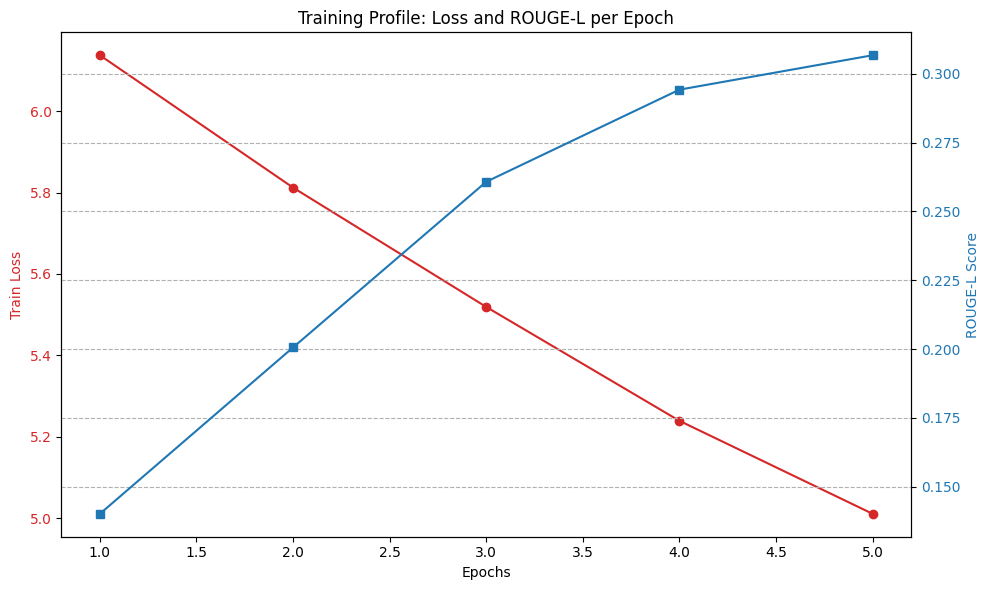

In [60]:
# Plot training history
plot_history(train_losses, valid_rouges)

* Train Loss (màu đỏ) giảm liên tục và ổn định từ mức khoảng 6.15 xuống còn gần 5.0 sau 5 epochs. Điều này cho thấy mô hình đang học tốt.

* ROUGE-L Score (màu xanh) tăng mạnh từ khoảng 0.14 lên hơn 0.30. Mô hình đang thực sự cải thiện khả năng tạo câu có nghĩa.

In [61]:
# Evaluation function using ROUGE-L
final_rouge = evaluate_rouge(model, test_loader, vi_vocab)
print(f"Final ROUGE-L: {final_rouge:.4f}")

Evaluating: 100%|██████████| 63/63 [00:46<00:00,  1.37it/s]


Final ROUGE-L: 0.3147


* Kết quả 0.3147 cho thấy mô hình hiện tại đã có khả năng dịch các câu với độ chính xác về từ vựng và cấu trúc ngữ pháp tương đối tốt. Điểm trên tập Test (0.3147) cao hơn một chút so với Validation (~0.3068) cho thấy mô hình có khả năng tổng quát hóa.

* Kết quả mô hình Luong Attention đạt 0.3147, cao hơn so với mô hình Seq2Seq thông thường (0.25). Tốc độ hội tụ của mô hình rất nhanh, đặc biệt là giảm mạnh Loss trong 3 epoch đầu tiên nhờ khả năng tập trung vào các từ quan trọng nhất ở câu gốc tại mỗi bước dịch thay vì ép toàn bộ ý nghĩa câu vào một vector duy nhất dễ gây mất dữ liệu như model không có attention.

* Trong thực tế, Luong Attention thường được đánh giá cao hơn về tính ứng dụng và hiệu suất nhờ cấu trúc tính toán linh hoạt và tốc độ xử lý nhanh. Mặc dù Bahdanau Attention có thể có độ chính xác cao hơn nhờ sử dụng phép cộng phi tuyến tính phức tạp, nhưng Luong lại chiếm ưu thế nhờ sử dụng phép nhân ma trận (Dot-product) tối ưu hóa rất tốt trên GPU. Sự cân bằng giữa độ chính xác khá cao và tiết kiệm tài nguyên đã khiến Luong Attention trở thành lựa chọn phổ biến trong các hệ thống dịch máy và tóm tắt văn bản thực tế trước khi kiến trúc Transformer ra đời.

In [90]:
sentence = " you can talk with me"
translation = translate_sentence(sentence, en_vocab, vi_vocab, model, device)
print(f'Predicted: {translation}')

Predicted: bạn bạn bạn nói về tôi
